In [3]:
!pip install unrar
!unrar x /content/Dataset2.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset2.rar

Creating    Dataset 2                                                 OK
Creating    Dataset 2/faringitis                                      OK
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.5818f7fd9c45883c801d938b09b29755.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.a04e34f6d58fe952bc090614f030910c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.b120ee8edff9c00d1f305d865b733a42.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.6bd81eac38835aee94df9c1e5079d67c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.873f55c8af860852930aef580ce9463d.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.c1c8132c26736bc54117fbc7d64a2714.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1583073772026_jpeg.rf.61c

In [4]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import pandas as pd
import pathlib
from keras_tuner.tuners import RandomSearch

base_dir = '/content/Dataset 2'


In [26]:
import pandas as pd
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_dir = pathlib.Path("/content/Dataset 2")


image_extensions = ['.jpg', '.jpeg', '.png']
all_images = [p for p in base_dir.rglob('*') if p.suffix.lower() in image_extensions]


df = pd.DataFrame({
    'filename': [str(p) for p in all_images],
    'class': [p.parent.name for p in all_images]
})


train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)


validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)


test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)


Train: 1722, Val: 494, Test: 244
Found 1722 validated image filenames belonging to 2 classes.
Found 494 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


In [27]:
print(train_generator.class_indices)


{'faringitis': 0, 'normal': 1}


In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_pharyngitis2.keras', save_best_only=True)
]


In [31]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 59s 439ms/step - accuracy: 0.4881 - loss: 0.7740 - val_accuracy: 0.5992 - val_loss: 0.6565
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - accuracy: 0.5449 - loss: 0.7182 - val_accuracy: 0.6296 - val_loss: 0.6339
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 272ms/step - accuracy: 0.5982 - loss: 0.6841 - val_accuracy: 0.7206 - val_loss: 0.6221
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.6608 - loss: 0.6234 - val_accuracy: 0.7085 - val_loss: 0.6003
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 272ms/step - accuracy: 0.6559 - loss: 0.6288 - val_accuracy: 0.7328 - val_loss: 0.5873
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 273ms/step - accuracy: 0.7008 - loss: 0.6032 - val_accuracy: 0.7368 - val_loss: 0.5752
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 276ms/step - accuracy: 0.7153 - loss: 0.5833 - val_accuracy: 0.7470 - val_loss: 0.5650
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 273ms/step - accuracy: 0.7197 - loss: 0

In [32]:

for layer in base_model.layers:
    if layer.name.startswith('block5_') or layer.name.startswith('block4_'):
        layer.trainable = True


optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 13,110,785 (50.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [33]:
history_finetune = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 370ms/step - accuracy: 0.7679 - loss: 0.4846 - val_accuracy: 0.8785 - val_loss: 0.2908
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 67s 302ms/step - accuracy: 0.8622 - loss: 0.3307 - val_accuracy: 0.9028 - val_loss: 0.2180
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 304ms/step - accuracy: 0.9057 - loss: 0.2368 - val_accuracy: 0.9393 - val_loss: 0.1658
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 32s 294ms/step - accuracy: 0.9361 - loss: 0.1787 - val_accuracy: 0.9150 - val_loss: 0.1729
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 313ms/step - accuracy: 0.9351 - loss: 0.1636 - val_accuracy: 0.9312 - val_loss: 0.1561
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - accuracy: 0.9549 - loss: 0.1172 - val_accuracy: 0.9534 - val_loss: 0.1174
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 312ms/step - accuracy: 0.9532 - loss: 0.1213 - val_accuracy: 0.9555 - val_loss: 0.1056
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.9617 - loss: 0

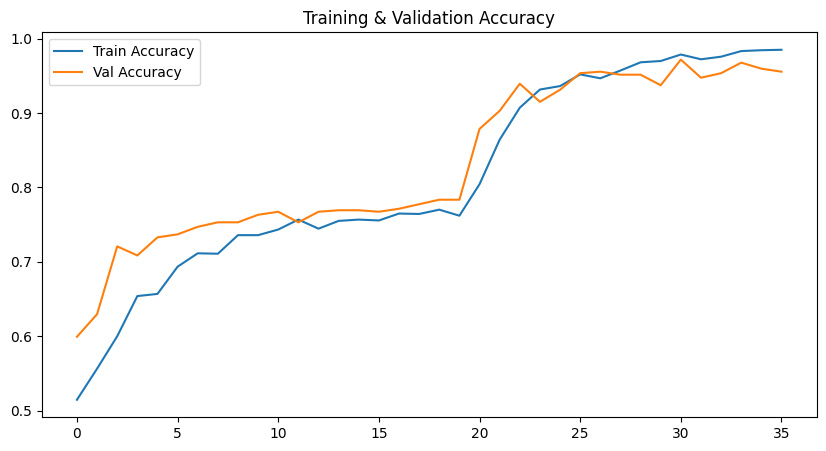

In [34]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.9940 - loss: 0.0348
Test Accuracy: 0.9877


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
Evaluasi best_model hasil tuning:
              precision    recall  f1-score   support

  faringitis       0.99      0.98      0.98        98
      normal       0.99      0.99      0.99       146

    accuracy                           0.99       244
   macro avg       0.99      0.99      0.99       244
weighted avg       0.99      0.99      0.99       244



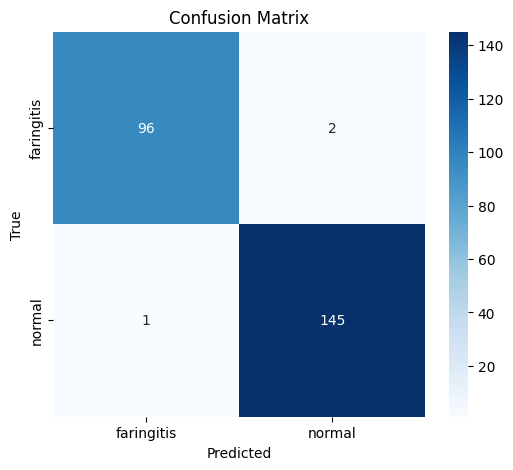

In [36]:
test_generator.reset()
Y_pred_best = model.predict(test_generator)
y_pred_best = (Y_pred_best > 0.5).astype(int).reshape(-1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluasi best_model hasil tuning:")
print(classification_report(test_generator.classes, y_pred_best, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [37]:
model.save('VGG16_notuner_aug.keras')


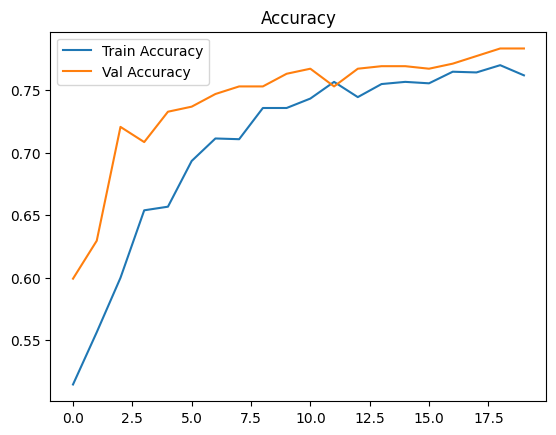

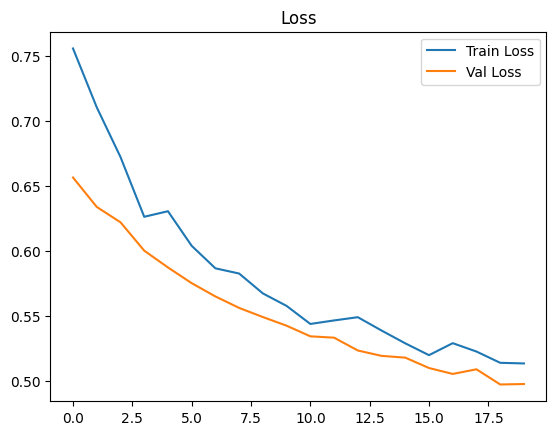

In [38]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()
